In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from IPython.display import clear_output
#%matplotlib inline

## <center>Self-organization of multi-layer spiking neural networks: Python implementation and explanation</center>
_____

The purpose of this notebook is to translate DS__spikingNN_LIFL.m into python and get a solid understanding of the dynamical Systems form of the Spiking NN Developmental algorithm. The matlab file and the paper [Self-organization of multi-layer spiking neural networks](https://arxiv.org/pdf/2006.06902.pdf) were referenced in making this implementation.

### Overarching ideas
___
**What causes the self-organization of a developing embryo's neural network?**

* Spontaneous spatio-temporal neural activity waves in the brain (including the retina)
* these waves establish connectivity between the retina, LGN, and V1
* happens before the onset of vision

**What is the architecture?**

* pooling from retina to LGN, expansion from LGN to V1.

**What are the components of this network?**

* spiking neurons
* spatiotemporal waves
* STDP learning rules
* competition rules


**What is the order of events?**
* establish the waves in each layer
* update the threshold and voltage of neurons every time step
* learning rule to update inter-layer connectivity based on the waves

### Neuron type: Modified Leaky-Integrate-and-Fire (LIF)
____
Neuronal dynamics are defined by a summation process and a mechanism that triggers action potentials above a critical voltage. If the voltage $v_i$ containing the summed effects of all inputs exceeds its threshold $\theta_i$, we say the neuron $i$ fires a spike, and the firing time is $t_i$. The time-step change in voltage and threshold is governed by the equations below. In this implementation, the threshold is dynamical.


$$\frac{d}{dt}\boldsymbol{v} = \frac{1}{\tau _v}(-\boldsymbol{v} +\boldsymbol{S}H(\boldsymbol{v}-\boldsymbol{\theta}) + \boldsymbol{S}^x\boldsymbol{x})$$

$$\frac{d}{dt}\boldsymbol{\theta} = -\frac{1}{\tau _\theta}(v^{th}-\boldsymbol{\theta}) \odot  (1-H(\boldsymbol{v}-\boldsymbol{\theta}))+\theta^+H(\boldsymbol{v}-\boldsymbol{\theta})$$

After firing, a neuron's voltage is reset to $v^{reset}$.

### Key
| variable | definition |
| --- | --- |
| $v$ | voltage |
| $\theta$ | variable firing threshold |
| $x$ | input signal to this layer |
| $H$ | (element-wise) heavy-side function |
| $\odot$ | Hadamard product |
| $\boldsymbol{S}$ | intra-layer adjacency matrix |
| $\boldsymbol{S}^{x}$ | (optional) spike input matrix |

We encode the geometry of the layer and an isotropic kernel with a tunable excitation and inhibition
radius and amplitude factors into S. The kernel leads to positive intra-layer neuronal connectivity inside the excitation radius $r_i$ and decaying negative connections outside the inhibition radius $r_o$


### Setting up Retina, LGN, and V1 Structure Parameters
___

In [45]:
# System Constants and Parameters
nR = 1600     # Neurons in Retina
nL = 300       # Neurons in LGN
nV = 400       # Neurons in V1n length of Retina
sqR = 28
sqL = 6

In [46]:
def adjacency(D, ai, ao, ri, ro):
    """Calculate intra-layer adjacency matrix encoding the spatial connectivity 
    of neurons within the layer.

    Parameters
    ----------
    D  : distance matrix
    ai : inhibition amplitude factor
    a0 : excittation amplitude factor
    ri : float
        Excitation radius
    ro : float
        Inhibition radius
    """
    
    S = ai * (D < ri) - (ao * (D > ro) *  np.exp(-D/10))  
    S = S - np.diag(np.diag(S)) 

    return S

In the paper, S is determined like this:
$$S_{i,j} = \begin{Bmatrix}
a^i & D_{i,j} < r^i \\ 
 -a^oe^{(-D_{i,j}/10)},& D_{i,j} > r^o
\end{Bmatrix}$$
where $D_{i,j}$ $\epsilon$ $\mathbb{R}^{n_l\times n_l}$ is the matrix of spatial distances between each neuron and $a^i$/$a^o$ are the excitation and inhibition amplitude factors.

so should the line instead multiply the actual value of D by 16 at the indices where D < ri, instead of just 16 * 1 at those indices?

In [47]:
# Retina 

Ret = {
    "tf" : np.zeros((nR, 1)),
    "th" : np.ones((nR, 1)), # variable retina threshold (theta)
    "b" : np.zeros((nR, 1)),
    "v_reset" : .1 * np.random.randn(nR, 1)**2,
    "nx" : sqR * np.random.rand(nR, 2),
    "ri" : 2, # inner radius
    "ro" : 5, # outer radius
    "u" : np.zeros((nR,1)),  # I.C. of v, u
    "v" :  np.zeros((nR, 1)),
    "H" : np.zeros((nR, 1)) # OG has sparse, see if this will be an issue TODO
    # "H" :  sparse(np.zeros((nR,1))) find sparse version in numpy

}
Ret["D"] = squareform(pdist(Ret["nx"])) # distance
Ret["S"] = adjacency(Ret["D"], 16, 3, Ret["ri"], Ret["ro"]) # adjacency matrix 

In [48]:
Ret["S"].shape

(1600, 1600)

In [49]:
# LGN

LGN = {
    "eta_learn" : .1,
    "synapticChanges" : np.zeros((nL, 1)),
    "thresh" : np.random.normal(40,2,(nL,1)), # Normal distribution around 70 +- 2 (std. dev) Normal distribution around 70 +- 2 (std. dev)
    "nx" : sqL * np.random.rand(nL, 2),
    "ri" : 1.2, # inner radius
    "ro" : 1.3, # outer radius
    "v" :  np.zeros((nL,1)),
    "u" : np.zeros((nL,1)), # I.C. of v, u
    # "H" :  sparse(np.zeros((nL,1))) find sparse version in numpy?
    "H" : np.zeros((nL, 1)),
    "th" : np.ones((nL, 1)),
    "b" : np.zeros((nL, 1)),
    "v_reset" : .1 * np.random.randn(nL, 1)**2 # noisy voltage reset

}

LGN["D"] = squareform(pdist(LGN["nx"])) # distance
LGN["S_d"] = adjacency(LGN["D"], .04, .01,  LGN["ri"], LGN["ro"]) # in original code, doesn't use diag, but ends up being the same since diag is 0
LGN["S"] =  adjacency(LGN["D"], .60, 15,  LGN["ri"], LGN["ro"]) # adjacency matrix between neurons in LGN


In [50]:
# V1
V1 = {
    "eta_learn" : 0.15,
    "synapticChanges" : np.zeros((nV, 1)),
    "thresh" : np.random.normal(30, 2, (nV, 1)),
    "activity" : [],
}

### Setting Weight Matrices
There will be two weight matrices, one that defines the connections between the retina and LGN, and one that defines the connections between LGN and V1. 
____

In [51]:
# Synaptic Weight Matrix I (Ret-LGN1)

mu_W1 = 2.5
sigma_W1 = 0.14
W1 = np.random.normal(mu_W1, sigma_W1, (nR,nL))
W1 = W1/np.mean(W1, axis = 0) * mu_W1    # Weight Matrix between Retina-LGN1 normrnd initialized take column mean


In [52]:
# Synaptic Weight Matrix II (LGN1-V1)

mu_W2 = 2.5
sigma_W2 = 0.14
W2 = np.random.normal(mu_W2, sigma_W2, (nL,nV))
W2 = W2/np.mean(W2, axis = 0) * mu_W2    # Weight Matrix between Retina-LGN1 normrnd initialized


### Initialization

Here we set up the time step `dt`, hyperparameters $\tau _v$, $\tau _\theta$, $\tau _u$, $v^{th}$, and $\theta^+$, and  the following arrays:

| array (in the code) | purpose |
| --- | --- |
| `Xu` | stores $SH$ of retina neurons for each time step |
| `Xv` | stores voltage of retina neurons for each time step|
| `Xth` | stores threshold of retina neurons for each time step |
| `Lu` | stores $SH$ of LGN neurons for each time step |
| `Lv` | stores voltage of LGN neurons for each time step |
| `Lth` | stores threshold of LGN neurons for each time step |
| `Ly` | stores winning LGN neurons for each time step (input signal, <br> vector with 0s everywhere except k neurons that received most activation from retina layer) |


In [53]:
Tend = 300; dt = 0.1; t_intrvls = np.arange(0,Tend + 1) # (301,) shape

fnoise = 3*np.random.randn(nR,len(t_intrvls)); # Pre-generate noise
# fnoiseI?


Xu = np.zeros((nR,t_intrvls[-1])); Xu[:,0] = Ret["u"].reshape(nR,) # Snapshot matrix u
Xv = np.zeros((nR,t_intrvls[-1])); Xv[:,0] = Ret["v"].reshape(nR,) # Snapshot matrix v
Xth = np.zeros((nR,t_intrvls[-1])); Xth[:,0] = Ret["th"].reshape(nR,)


Lu = np.zeros((nL,t_intrvls[-1])); Lu[:,0] = LGN["u"].reshape(nL,) #Snapshot matrix u
Lv = np.zeros((nL,t_intrvls[-1])); Lv[:,0] = LGN["v"].reshape(nL,); #Snapshot matrix v
Lth = np.zeros((nL,t_intrvls[-1])); Lth[:,0] = LGN["th"].reshape(nL,);
Ly = np.zeros((nL,t_intrvls[-1]))

tau_v = 2; tau_u = 0.3;
tau_th = 60; th_plus = 9; v_th = 1;




`firedMat` and `fireLMat` are dictionaries with integer values as keys, and will store which neurons fire on a second-by-second basis

In [54]:
firedMat = {} # cell(1,length(t_intrvls)); 
fireLMat = {} #cell(1,length(t_intrvls));


### Time Loop

Here is the most important part of the model. For each time step, we do the following:
1. Set noise for the retina $\boldsymbol{S}^x\boldsymbol{x}$ term as an input signal(`Ret["eta"]`)
2. Calculate retina $\boldsymbol{S}H = $  `Ret["u"]` term (solving wave dynamical system)
3. Update retina voltage and threshold according to modified LIF neuron rules
4. Determine which retina neurons are above their threshold and therefore fire
5. Reset the voltage of the retina neurons that fire
6. Set `H` for firing neurons
7. Calculate inputs to LGN based on weight matrix and retina neurons that fired (inputs = `LGN["x"]`)
8. ReLu activation function on LGN input with a threshold value `LGN["thresh"]`
9. Find value and indices of k maximum input values from (8)
10. "Winner take-all" competition rule: make all values of `LGN["y"]` be 0 except for the max k values from (9)
11. Learning rule: Update weight matrix between Retina and LGN so that the neurons that fired in the Retina <br> are more connected to (have higher weights) with the "winning" LGN neuron (solve W1 Matrix dynamical system)
12. Increase `LGN["thresh"]` so its less likely the same 'winning' neuron will win again 

#### Now repeat for higher layers
13. Calculate `LGN["u"]` term, which encompasses $\boldsymbol{S}H$ and $\boldsymbol{S}^x\boldsymbol{x}$ (using input signal `LGN["y"]`)(solve Wave dynamical system in LGN)
14. Update LGN voltage and threshold according to modified LIF neuron rules
16. Determine which LGN neurons are above their threshold and therefore fire
17. Reset the voltage of the LGN neurons that fire
18. Set `H` for firing neurons
19. Calculate inputs to V1 based on weight matrix (`W2`) and LGN neurons that fired (inputs = `V1["x"]`)
20. ReLu activation function on V1 input with a threshold value `V1["thresh"]`
21. Find value and indices of k maximum input values from (20)
22. "Winner take-all" competition rule: make all values of `V1["y"]` be 0 except for the max k values from (21)
23. Learning rule: Update weight matrix between LGN and V1 so that the neurons that fired in the LGN <br> are more connected to (have higher weights) with the "winning" V1 neuron (solve W2 Matrix dynamical system)
24. Increase `V1["thresh"]` so its less likely the same 'winning' neuron will win again 

#### Storing Values

25. Within this loop, every second (dt is a multiple of 1), store values in `Xv`, `Xu`, `Xth`, `Lu`, `Lv`, `Lth`, and `Ly`. 
26. Plot the LGN spikes (`LGN["y"]` and `LGN["thresh"]` versus neuron number for each second). This plot shows the threshold for the activation function, and which neuron in the LGN 'wins' in the competition rule. This is not the neuron that spikes necessarily, but it is the neuron that ultimately is getting the input from the previous layer for that time step. 
27. Plot the V1 spikes (`V1["y"]` and `V1["thresh"]` versus neuron number for each second)

        

   
`u` = $\boldsymbol{S}H$ <br>
`eta` = $\boldsymbol{S}^x\boldsymbol{x}$ <br>
`H` = 1 for a firing neuron, 0 otherwise <br>
`fired` = indices of fired neurons <br>



$$\frac{d}{dt}\boldsymbol{v} = \frac{1}{\tau _v}(-\boldsymbol{v} +\boldsymbol{S}H(\boldsymbol{v}-\boldsymbol{\theta}) + \boldsymbol{S}^x\boldsymbol{x})$$

$$\frac{d}{dt}\boldsymbol{\theta} = -\frac{1}{\tau _\theta}(v^{th}-\boldsymbol{\theta}) \odot  (1-H(\boldsymbol{v}-\boldsymbol{\theta}))+\theta^+H(\boldsymbol{v}-\boldsymbol{\theta})$$

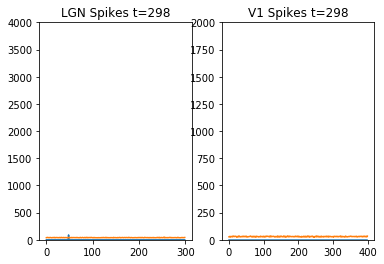

In [55]:
for tt in np.arange(0, Tend, dt):

    if tt < 299:
        Ret["eta"] = fnoise[:,int(np.round(tt)+1)].reshape(1600,1) # TODO: rounding
    
    # Solve Wave Dynamical System in Retina
    Ret["u"] = np.matmul(Ret["S"],Ret["H"]) # TODO: fix ret.H --> 1600 x 1 of zeros
    
    # use RK4 function or can i just do it this way?
    ## voltage and threshold update rules
    
    Ret["v"] = Ret["v"] + dt * (1/tau_v * (-Ret["v"] + Ret["u"] + Ret["b"] + Ret["eta"]))
    #Ret["v"] = Ret["v"] + dt * -1/tau_v * Ret["v"] + Ret["u"] + Ret["b"] + Ret["eta"] # incorrect

    Ret["th"] = Ret["th"] +  dt * (1/tau_th * (v_th - Ret["th"]) * (1-Ret["H"]) + th_plus * Ret["H"]) 
                               
    # Ret.v = RK4(@(v)(-1/tau_v *v + Ret.u + Ret.b + Ret.eta),  dt,Ret.v);
    # Ret.th = RK4(@(th)(1/tau_th*(v_th-th).*(1-Ret.H) + th_plus*Ret.H),  dt,Ret.th);
    
    # Discontinuous update rule
    fired = np.argwhere(Ret["v"] >= Ret["th"])[:,0] # get only row indices (#rows, ) shape
    Ret["v"][fired] = Ret["v_reset"][fired] # replacing voltages of fired neurons with reset voltage
    Ret["H"] = np.zeros((nR, 1)) 
    Ret["H"][fired,] = np.ones((len(fired),1)) # 1s where the neurons fire in H #TODOL make sparse
    
    # Inputs to LGN
    LGN["x"] = np.matmul(np.transpose(W1) , Ret["H"]) # the neurons that fired are 1, get multipled by weight --> 300 x 1 matrix
    
    # LGN Activation function
    LGN["y"] = np.maximum(LGN["x"] - LGN["thresh"], 0) # ReLU activation function 
    # difference between LGN['thresh'] and LGN['th'] is that thresh is basically a threshold value for the ReLu
    # amount by how much input signal lies over thresh. identity if over thresh, 0 otherwise
    
    win, maxInd = np.max(LGN["y"]), np.argmax(LGN["y"])
    # wink, maxInd = maxk(LGN.y,1) #  ALTERNATIVELY: find Index of k best performers
    
    # LGN competition rule
    LGN["y"][LGN["y"] < win] = 0 # only allow winner to participate (make all other entries 0)
    #     LGN.y(maxInd) = (LGN.y(maxInd)/(wink(1)+eps)).^4 .*LGN.y(maxInd); do i need this??

    # Output of LGN
    # LGN["y"] = csr_matrix(LGN["y"]) sparse messes up next calculation
    
    # Solve W1 Matrix dynamical system & Update thresh
    W1 = W1 + dt * (np.matmul(LGN["eta_learn"] * Ret["H"], np.transpose(LGN["H"]))) 
    LGN["thresh"] = LGN["thresh"] + dt * (0.005 * LGN["y"])
    W1[:,maxInd] = (W1[:,maxInd]/np.mean(W1[:,maxInd]))*mu_W1 # not sure purpose of this
    
    
    # Solve Wave Dynamical System in LGN
    LGN["u"] = np.matmul(LGN["S"],LGN["H"]) + np.matmul(LGN["S_d"], LGN["y"])    
    LGN["v"] = LGN["v"] + dt * (1/tau_v * (-LGN["v"] + LGN["u"]))
    #LGN["v"] = LGN["v"] + dt * (-1/tau_v * LGN["v"] + LGN["u"]) # incorrect

    LGN["th"] = LGN["th"] +  dt * (1/tau_th * (v_th - LGN["th"]) * (1-LGN["H"]) + th_plus * LGN["H"])     
        
    # use RK4 function or can i just do it this way?
    ## voltage and threshold update rules
    
    # Discontinuous update rule in LGN
    fireL = np.argwhere(LGN["v"] >= LGN["th"])[:,0] # get only row indices (#rows, ) shape
    LGN["v"][fireL] = LGN["v_reset"][fireL] # replacing voltages of fired neurons with reset voltage
    LGN["H"] = np.zeros((nL, 1)) 
    LGN["H"][fireL,] = np.ones((len(fireL),1)) # 1s where the neurons fire in H #TODOL make sparse

    # Inputs to V1
    V1["x"] = np.matmul(np.transpose(W2) , LGN ["H"]) 
    
    # V1 activation function
    V1["y"] = np.maximum(V1["x"] - V1["thresh"], 0) # activation function amount by how much input signal lies over thresh  ReLU activation function 
    win, maxInd = np.max(V1["y"]), np.argmax(V1["y"])
    #     [wink, maxInd] = maxk(V1.y,40); % ALTERNATIVELY: find Index of k best performers #TODO change to 40 highest argsort?

    # V1 competition rule
    V1["y"][V1["y"] < win] = 0 # only allow winner to participate (make all other entries 0) #TODO make wink
    #   V1.y(maxInd) = (V1.y(maxInd)/(wink(1)+eps)).^4 .*V1.y(maxInd); do i need this??

    
    # Assemble system
    # V1["y"] = csr_matrix(V1["y"])
    
    # Solve W2 Matrix dynamical system & Update thresh
    W2 = W2 + dt * (np.matmul(V1["eta_learn"] * LGN["H"], np.transpose(V1["y"]))) 
    V1["thresh"] = V1["thresh"] + dt * (0.005 * V1["y"])
    W2[:,maxInd] = (W2[:,maxInd]/np.mean(W2[:,maxInd]))*mu_W2
    
    if np.mod(tt, 1) == 0 and tt != 299:
        
        tt = int(tt)
        Xv[:,tt+1] = Ret["v"].reshape(1600,); Xu[:,tt+1] = Ret["u"].reshape(1600,)
        Xth[:,tt+1] = Ret["th"].reshape(1600,);
        Lv[:,tt+1] = LGN["v"].reshape(300,); Lu[:,tt+1] = LGN["u"].reshape(300,)
        Lth[:,tt+1] = LGN["th"].reshape(300,); Ly[:,tt+1] = LGN["y"].reshape(300,);        
        firedMat[tt+1] = fired; fireLMat[tt+1] = fireL; # making firedMat a dictionary rn
        
        plt.figure(1)
        plt.subplot(1,2,1); plt.plot(range(nL), LGN["y"][:]); plt.plot(range(nL), LGN["thresh"][:])
        plt.title('LGN Spikes t=' + str(tt))
        plt.ylim(0,4000)
        
        plt.subplot(1,2,2); plt.plot(range(nV), V1["y"][:]); plt.plot(range(nV), V1["thresh"][:])
        plt.title('V1 Spikes t=' + str(tt))
        plt.ylim(0,2000)
        plt.show()

        clear_output(wait=True)

        
        # add weight matrix heatmap?
                        

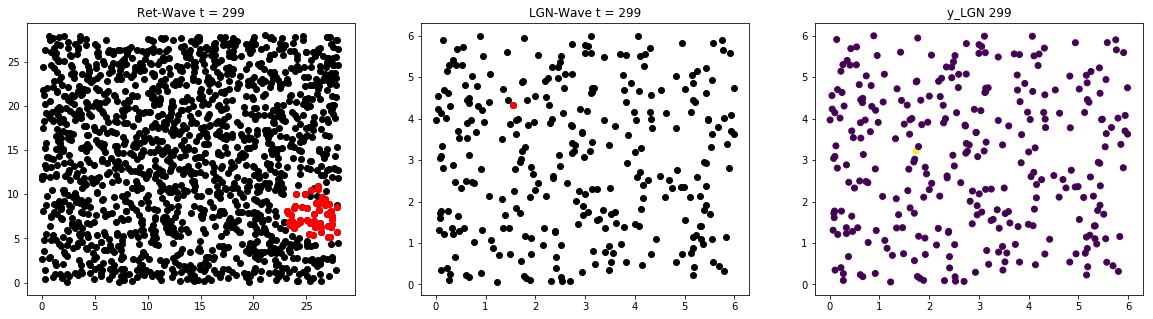

In [59]:
# Visualization of Wave
for ii in range(1, 300):
    f = plt.figure(figsize=(20,5))

    ax1 = f.add_subplot(131)
    ax1.title.set_text('Ret-Wave t = ' + str(ii))
    ax1.scatter(Ret['nx'][:,1],Ret['nx'][:,0], color = 'k')
    ax1.scatter(Ret['nx'][firedMat[ii],1],Ret['nx'][firedMat[ii],0], color = 'r')
    
    ax2 = f.add_subplot(132); ax2.title.set_text('LGN-Wave t = ' + str(ii))
    ax2.scatter(LGN['nx'][:,1],LGN['nx'][:,0], color = 'k')
    ax2.scatter(LGN['nx'][fireLMat[ii],1],LGN['nx'][fireLMat[ii],0], color = 'r')
    
    ax3 = f.add_subplot(133); ax3.title.set_text('y_LGN ' + str(ii))
    ax3.scatter(LGN["nx"][:,1],LGN["nx"][:,0], c = Ly[:,ii])
    plt.show()
    clear_output(wait=True)
    
    

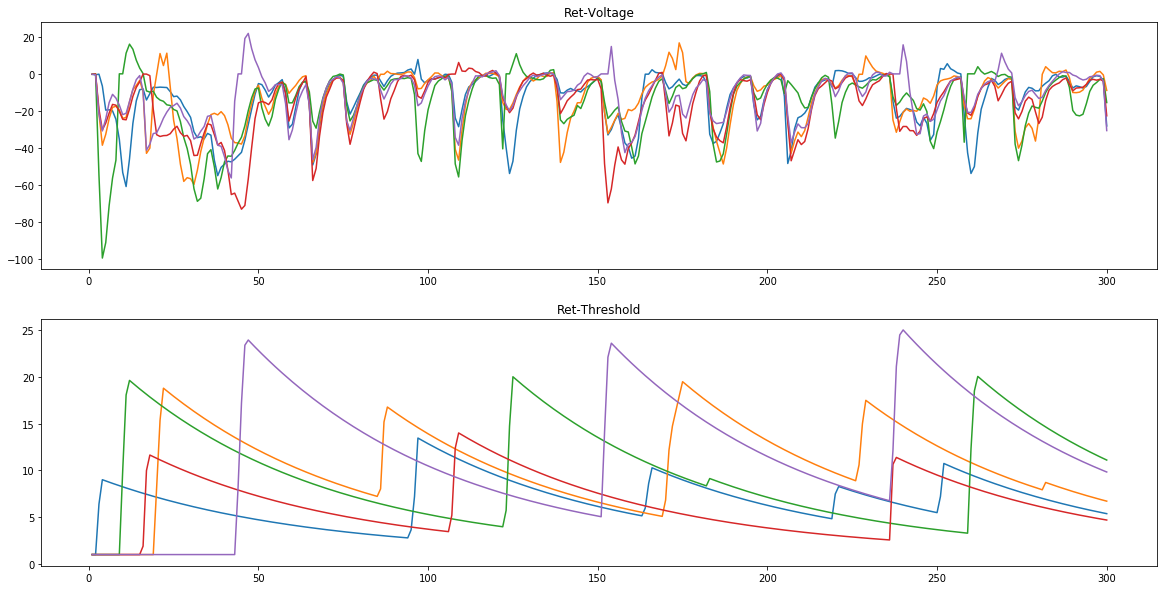

In [58]:
# Visualization of Voltage Values of Retina (for 5 neurons)
f = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(211)
ax1.title.set_text('Ret-Voltage')

ax2 = f.add_subplot(212)
ax2.title.set_text('Ret-Threshold')

for nur_num in range(5):
    ax1.plot(np.arange(1,301),Xv[nur_num,:]) 
    ax2.plot(np.arange(1,301),Xth[nur_num,:])
   # ax1.legend()


    

In [57]:
Ret["eta"][10]

array([-2.12902324])

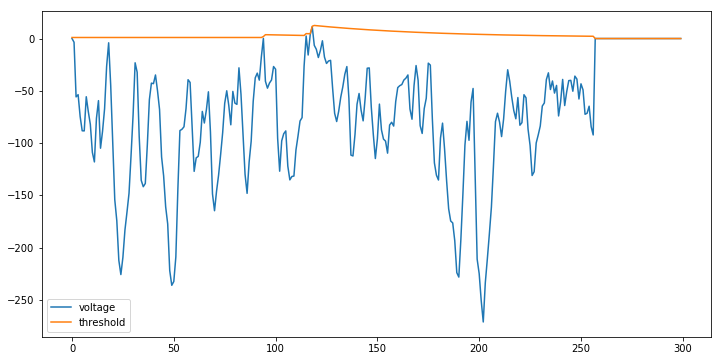

In [35]:
n = 10
plt.figure(figsize=(12,6))
plt.plot(Xv[n], label = 'voltage')
plt.plot(Xth[n], label = 'threshold')
plt.legend()

In [30]:
Ret['v_reset'][6]

array([0.11804437])

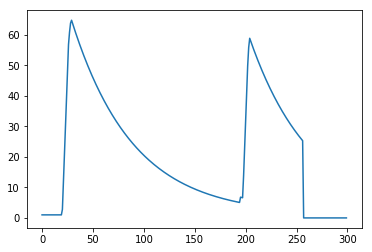

In [31]:
plt.plot(Xth[6])